In [8]:
import torch
import sys

sys.path.insert(1, '/home/rens/repos/hover_net')

from models.hovernet.net_desc import HoVerNet

net = HoVerNet(nr_types=6,mode='fast')
ckpt = torch.load('/home/rens/repos/premium_pathology/weights/hovernet_fast_pannuke_type_tf2pytorch.tar')
net.load_state_dict(ckpt['desc'], strict=True)
net.eval()
print('Setup complete')

Setup complete


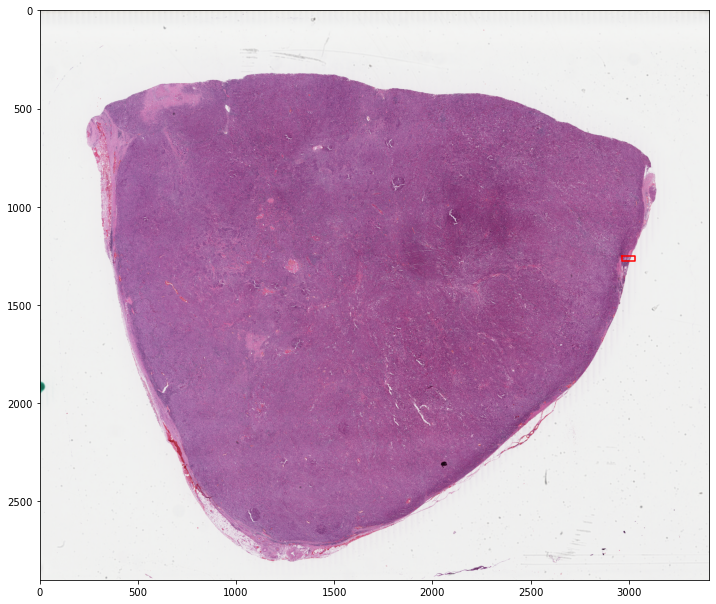

(109165, 92862)


In [10]:
import openslide
import numpy as np
import matplotlib.pyplot as plt

file_path = '/data/data/pathology/tcga/test/TCGA-3N-A9WC-01Z-00-DX1.C833FCAB-6329-4F90-88E5-CFDA0948047B.svs'

img = openslide.OpenSlide(file_path)
image = np.array(img.read_region((0,0), 3, img.level_dimensions[3]).convert('RGB'))

xmin, xmax, ymin, ymax = 95000,97000,40000,40900

plt.figure(figsize=(12,12))
plt.imshow(image)
plt.plot(
    (np.array([xmin,xmax,xmax,xmin,xmin]) / 32).astype(int),
    (np.array([ymin,ymin,ymax,ymax,ymin]) / 32).astype(int),
    color='red'
)
plt.show()

print(img.level_dimensions[0])

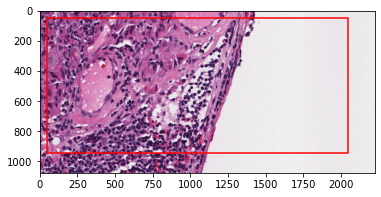

In [11]:
from math import ceil

def extract_patch(xmin, xmax, ymin, ymax):
    size_x = ceil((xmax-xmin) / 164) * 164 + 92
    size_y = ceil((ymax-ymin) / 164) * 164 + 92

    patch = np.array(img.read_region(
        (xmin-46,ymin-46), 0, (size_x,size_y)
    ))

    return patch

patch = extract_patch(xmin, xmax, ymin, ymax)

plt.imshow(patch)
plt.plot(
    [
        46,
        46+xmax-xmin,
        46+xmax-xmin,
        46,
        46
    ],
    [
        46,
        46,
        46+ymax-ymin,
        46+ymax-ymin,
        46
    ],
    c='red'
)
plt.show()

In [12]:
patch.shape

(1076, 2224, 4)

In [13]:
xx = np.arange(0,patch.shape[0], 164)[:-1]
yy = np.arange(0,patch.shape[1], 164)[:-1]

origins = np.array([(x,y) for y in yy for x in xx])

In [14]:
tiles = []
for x, y in origins:
        tiles.append(patch[x:x+256, y:y+256])

batch = torch.tensor(np.stack(tiles)[...,:-1].transpose(0,3,1,2))
batch.shape

torch.Size([78, 3, 256, 256])

In [15]:
net.to('cpu')
# batch.cuda()

with torch.no_grad():
    out = net(batch)

In [16]:
from collections import OrderedDict
import torch.nn.functional as F

def format_output(out):
    # format np
    pred_dict = OrderedDict(
        [[k, v.permute(0, 2, 3, 1).contiguous()] for k, v in out.items()]
    )
    pred_dict['np'] = F.softmax(pred_dict['np'], dim=-1)[...,1:]

    # format tp
    type_map = F.softmax(pred_dict["tp"], dim=-1)
    type_map = torch.argmax(type_map, dim=-1, keepdim=True)
    type_map = type_map.type(torch.float32)
    pred_dict["tp"] = type_map

    # to single array
    pred_output = torch.cat(list(pred_dict.values()), -1).numpy()

    return pred_output

pred_output = format_output(out)

In [17]:
import cv2
from scipy.ndimage import filters, measurements
from scipy.ndimage.morphology import (
    binary_dilation,
    binary_fill_holes,
    distance_transform_cdt,
    distance_transform_edt,
)

from misc.utils import get_bounding_box
from models.hovernet.post_proc import process, __proc_np_hv


def output2annotations(pred_output):
    pred_map = pred_output
    nr_types = 6
    return_centroids = False

    if nr_types is not None:
        pred_type = pred_map[..., :1]
        pred_inst = pred_map[..., 1:]
        pred_type = pred_type.astype(np.int32)
    else:
        pred_inst = pred_map

    pred_inst = np.squeeze(pred_inst)
    pred_inst = __proc_np_hv(pred_inst)

    inst_info_dict = None
    if return_centroids or nr_types is not None:
        inst_id_list = np.unique(pred_inst)[1:]  # exlcude background
        inst_info_dict = {}
        for inst_id in inst_id_list:
            inst_map = pred_inst == inst_id
            # TODO: chane format of bbox output
            rmin, rmax, cmin, cmax = get_bounding_box(inst_map)
            inst_bbox = np.array([[rmin, cmin], [rmax, cmax]])
            inst_map = inst_map[
                inst_bbox[0][0] : inst_bbox[1][0], inst_bbox[0][1] : inst_bbox[1][1]
            ]
            inst_map = inst_map.astype(np.uint8)
            inst_moment = cv2.moments(inst_map)
            inst_contour = cv2.findContours(
                inst_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
            # * opencv protocol format may break
            inst_contour = np.squeeze(inst_contour[0][0].astype("int32"))
            # < 3 points dont make a contour, so skip, likely artifact too
            # as the contours obtained via approximation => too small or sthg
            if inst_contour.shape[0] < 3:
                continue
            if len(inst_contour.shape) != 2:
                continue # ! check for trickery shape
            inst_centroid = [
                (inst_moment["m10"] / inst_moment["m00"]),
                (inst_moment["m01"] / inst_moment["m00"]),
            ]
            inst_centroid = np.array(inst_centroid)
            inst_contour[:, 0] += inst_bbox[0][1]  # X
            inst_contour[:, 1] += inst_bbox[0][0]  # Y
            inst_centroid[0] += inst_bbox[0][1]  # X
            inst_centroid[1] += inst_bbox[0][0]  # Y
            inst_info_dict[inst_id] = {  # inst_id should start at 1
                "bbox": inst_bbox,
                "centroid": inst_centroid,
                "contour": inst_contour,
                "type_prob": None,
                "type": None,
            }

    if nr_types is not None:
        #### * Get class of each instance id, stored at index id-1
        for inst_id in list(inst_info_dict.keys()):
            rmin, cmin, rmax, cmax = (inst_info_dict[inst_id]["bbox"]).flatten()
            inst_map_crop = pred_inst[rmin:rmax, cmin:cmax]
            inst_type_crop = pred_type[rmin:rmax, cmin:cmax, 0]
            inst_map_crop = (
                inst_map_crop == inst_id
            )  # TODO: duplicated operation, may be expensive
            inst_type = inst_type_crop[inst_map_crop]
            type_list, type_pixels = np.unique(inst_type, return_counts=True)
            type_list = list(zip(type_list, type_pixels))
            type_list = sorted(type_list, key=lambda x: x[1], reverse=True)
            inst_type = type_list[0][0]
            if inst_type == 0:  # ! pick the 2nd most dominant if exist
                if len(type_list) > 1:
                    inst_type = type_list[1][0]
            type_dict = {v[0]: v[1] for v in type_list}
            type_prob = type_dict[inst_type] / (np.sum(inst_map_crop) + 1.0e-6)
            inst_info_dict[inst_id]["type"] = int(inst_type)
            inst_info_dict[inst_id]["type_prob"] = float(type_prob)

    return inst_info_dict

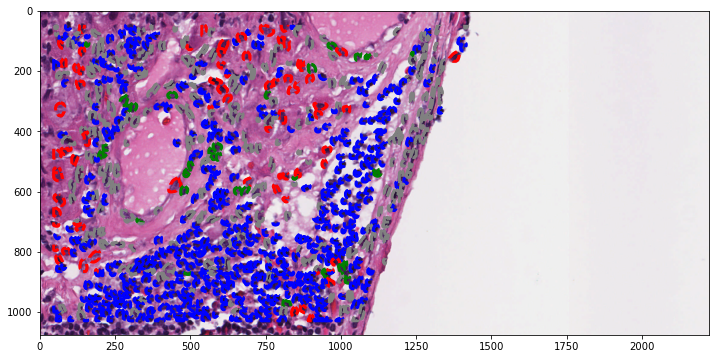

In [18]:
single_pred = pred_output[0]

inst_info_dicts = [output2annotations(pred) for pred in pred_output]

window = batch.numpy()[0].transpose(1,2,0)

type2color = {
    0:'gray',
    1:'r',
    2:'b',
    3:'gray',
    4:'gray',
    5:'g'
}


plt.figure(figsize=(12,12))
plt.imshow(patch)
for origin, inst_info_dict in zip(origins, inst_info_dicts):
    for inst in inst_info_dict.values():
        xx, yy = np.split(inst['contour'] + np.flip(origin,axis=0) + np.array([46,46]), 2, axis=-1)
        plt.plot(xx, yy, linestyle='--', lw=3, c=type2color[inst['type']])
plt.show()

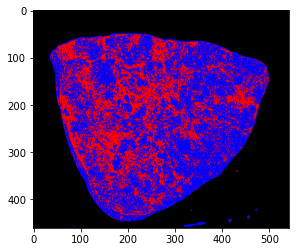

In [19]:
import os
from PIL import Image

annotation = np.array(Image.open('/data/data/pathology/tcga/TIL_maps_after_thres_v1/skcm/TCGA-3N-A9WC-01Z-00-DX1.png'))
plt.imshow(annotation)
plt.show()

In [20]:
annotation.shape

(461, 542, 3)

In [21]:
window = np.array([[xmin,ymin],[xmax,ymax]])
np.array([[xmin,ymin],[xmax,ymax]])

array([[95000, 40000],
       [97000, 40900]])

In [22]:
window = window / np.array(img.level_dimensions[0])* np.array(annotation.shape[:-1])
window

array([[401.18169743, 233.46471108],
       [409.6276279 , 238.71766708]])

In [23]:
window = np.array([[xmin,ymin],[xmax,ymax]])
window = window / np.array(img.level_dimensions[0]) * np.flip(np.array(annotation.shape[:-1]))
(annot_xmin, annot_ymin), (annot_xmax, annot_ymax) = window.astype(int)

In [24]:
img.level_dimensions[0]

(109165, 92862)

In [25]:
window = np.array([[xmin,ymin],[xmax,ymax]])
window

array([[95000, 40000],
       [97000, 40900]])

In [26]:
annotation.shape

(461, 542, 3)

In [27]:
window / np.array(img.level_dimensions[0])

array([[0.87024229, 0.4307467 ],
       [0.88856318, 0.4404385 ]])

In [28]:
(annot_xmin, annot_ymin), (annot_xmax, annot_ymax)

((471, 198), (481, 203))

In [29]:
(xmin, xmax), (ymin, ymax)

((95000, 97000), (40000, 40900))

In [32]:
annotation.shape

(461, 542, 3)

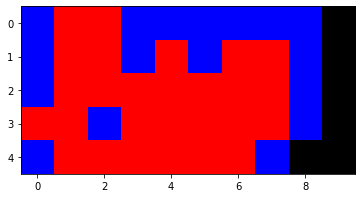

In [33]:
plt.imshow(annotation[annot_ymin:annot_ymax,annot_xmin:annot_xmax])

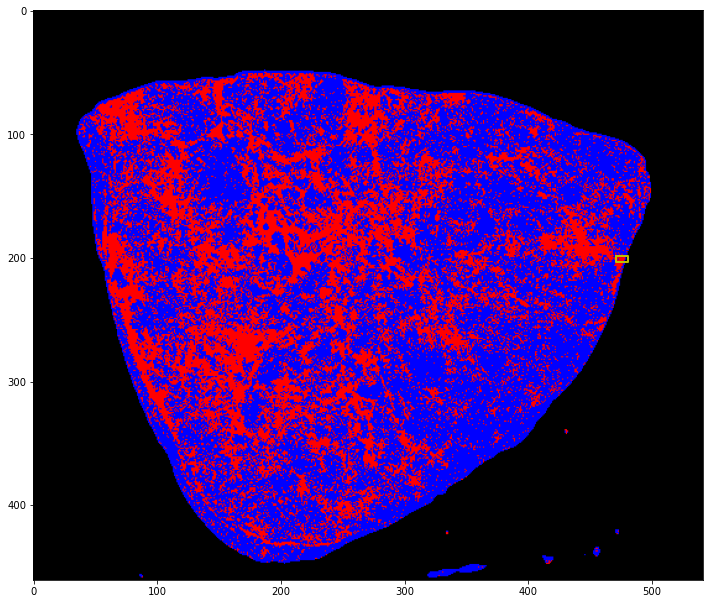

In [30]:
plt.figure(figsize=(12,12))
plt.imshow(annotation)
plt.plot(
    [annot_xmin,annot_xmax,annot_xmax,annot_xmin,annot_xmin],
    [annot_ymin,annot_ymin,annot_ymax,annot_ymax,annot_ymin],
    color='y',
    lw=2
)
plt.show()

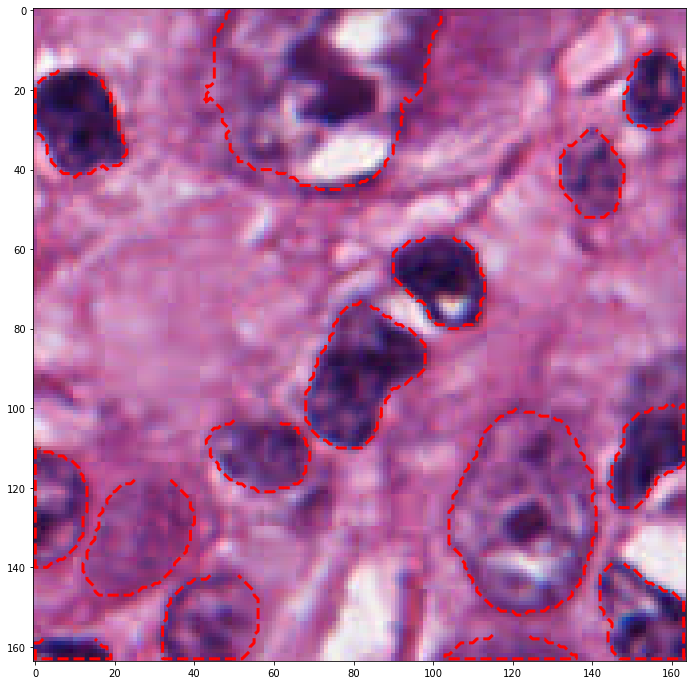

In [60]:
window = x.numpy().squeeze().transpose(1,2,0)[46:-46, 46:-46]

type2color = {
    0:'gray',
    1:'r',
    2:'b',
    3:'gray',
    4:'gray',
    5:'g'
}


plt.figure(figsize=(12,12))
plt.imshow(window)
for inst in inst_info_dict.values():
    xx, yy = np.split(inst['contour'], 2, axis=-1)
    plt.plot(xx, yy, linestyle='--', lw=3, c=type2color[inst['type']])
plt.show()

In [46]:
xx

array([[ 2],
       [ 1],
       [ 0],
       [ 0],
       [19],
       [19],
       [18],
       [18],
       [17],
       [15]], dtype=int32)

In [72]:
type2color = {
    0:'gray',
    1:'r',
    2:'b',
    3:'gray',
    4:'gray',
    5:'g'
}

(1, 164, 164, 1)

In [51]:
from models.hovernet.post_proc import process

process(pred_output, nr_types=6)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 46

In [32]:
import torch.nn.functional as F



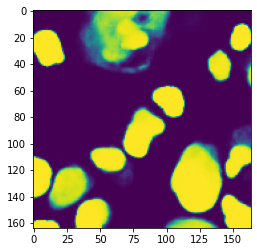

In [39]:
plt.imshow(pred_dict['np'].squeeze(dim=-1).detach().numpy().squeeze())
plt.show()

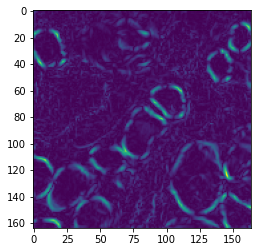

In [6]:
from skimage.filters import sobel_h, sobel_v

h,v = out['hv'][0].detach().numpy()

edges = abs(np.stack([
    sobel_h(h),
    sobel_v(v)
]).max(0))

plt.imshow(abs(edges))

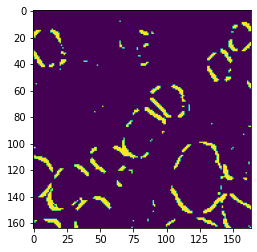

In [7]:
plt.imshow(edges > 0.15)

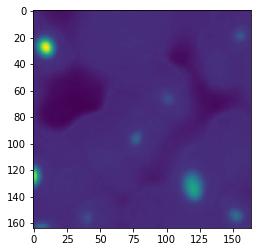

In [9]:
plt.imshow(out['np'][0,1].detach())

(array([4.9720e+03, 2.0932e+04, 4.7700e+02, 1.8900e+02, 1.2600e+02,
        9.8000e+01, 3.7000e+01, 2.7000e+01, 2.1000e+01, 1.7000e+01]),
 array([-21.428587 ,  -4.7932434,  11.8421   ,  28.477444 ,  45.11279  ,
         61.74813  ,  78.38348  ,  95.01882  , 111.65416  , 128.2895   ,
        144.92485  ], dtype=float32),
 <BarContainer object of 10 artists>)

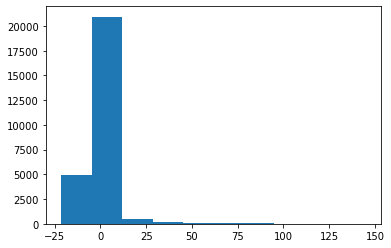

In [12]:
plt.hist(out['np'][0,1].detach().flatten().numpy())

(array([2.1312e+04, 5.0890e+03, 1.6400e+02, 1.1000e+02, 9.3000e+01,
        4.5000e+01, 3.1000e+01, 2.0000e+01, 1.9000e+01, 1.3000e+01]),
 array([ -6.7448616,   7.527604 ,  21.80007  ,  36.072536 ,  50.345    ,
         64.61747  ,  78.88993  ,  93.1624   , 107.43487  , 121.70733  ,
        135.9798   ], dtype=float32),
 <BarContainer object of 10 artists>)

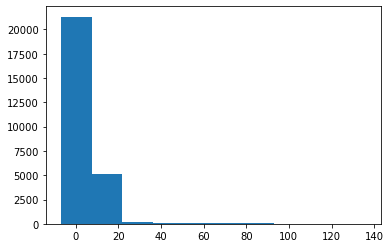

In [13]:
plt.hist(out['np'][0,0].detach().flatten().numpy())

KeyboardInterrupt: 

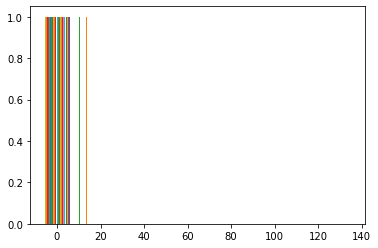

In [176]:
plt.hist(out['np'][0,0].detach().flatten())